<a href="https://colab.research.google.com/github/yyeseull/AI13/blob/main/AI_13_%EC%84%9C%EC%98%88%EC%8A%AC_section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

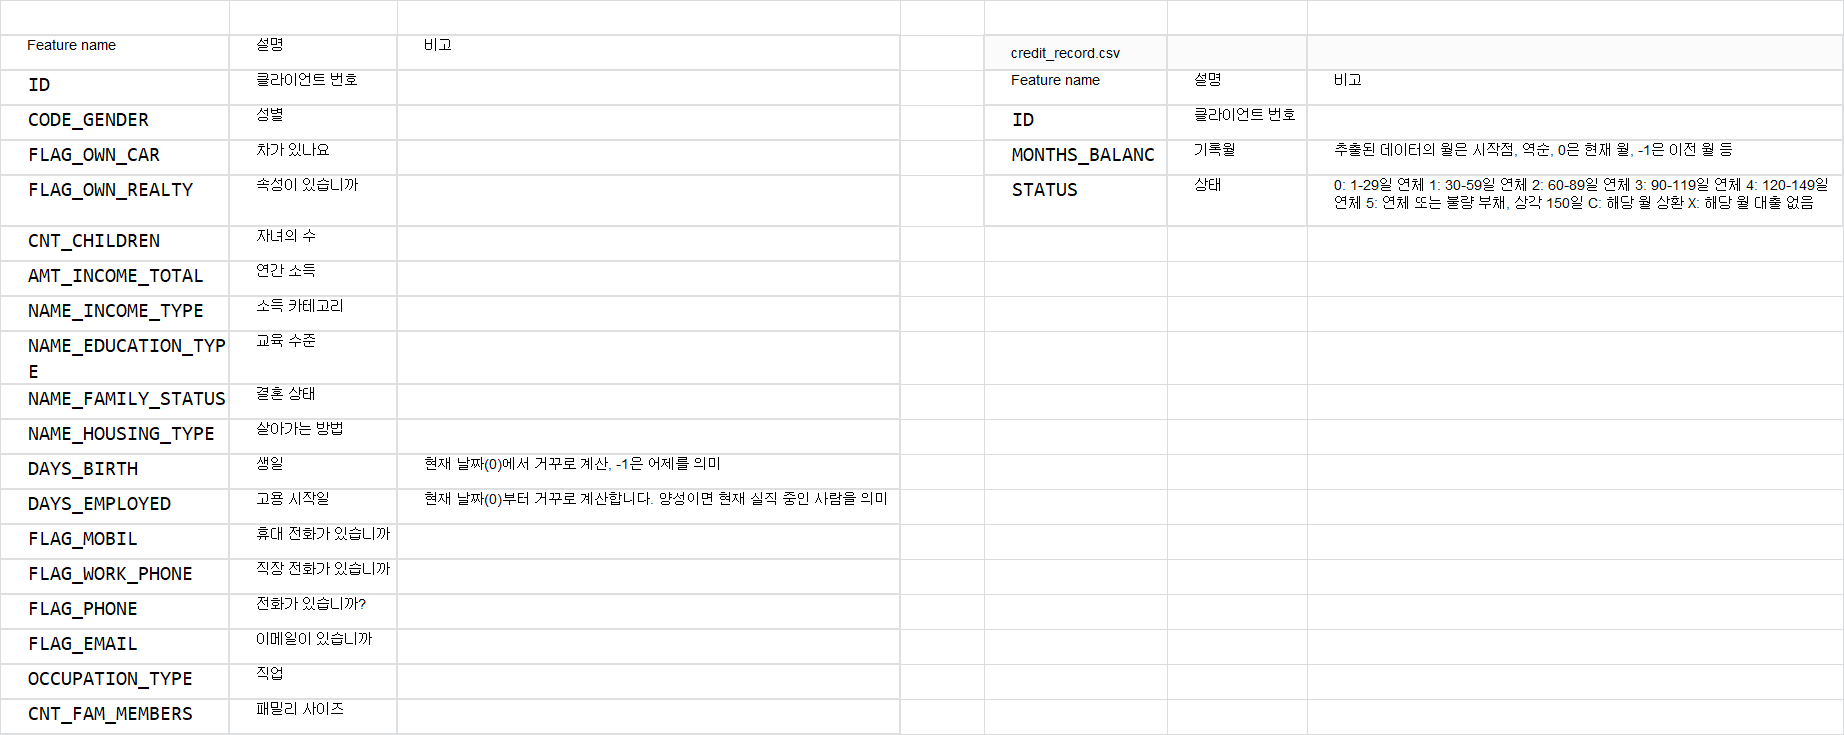

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

credit_record=pd.read_csv('/content/drive/MyDrive/archive/credit_record.csv') 
application_record=pd.read_csv('/content/drive/MyDrive/archive/application_record.csv') 


application_record

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [28]:
credit_record.head()


,ID,MONTHS_BALANCE,STATUS,MONTHS
0,5001711,0,0,0
1,5001711,-1,0,1
2,5001711,-2,0,2
3,5001711,-3,0,3
4,5001712,0,0,0


In [4]:
# application_record.T.duplicated() #중복확인


In [5]:
# credit_record.T.duplicated()

In [6]:
#결측치확인
application_record.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [7]:
credit_record.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [8]:
application_record.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

In [9]:
credit_record.nunique()

ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

In [10]:
application_record.info

<bound method DataFrame.info of              ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
2       5008806           M            Y               Y             0   
3       5008808           F            N               Y             0   
4       5008809           F            N               Y             0   
...         ...         ...          ...             ...           ...   
438552  6840104           M            N               Y             0   
438553  6840222           F            N               N             0   
438554  6841878           F            N               N             0   
438555  6842765           F            N               Y             0   
438556  6842885           F            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  

In [11]:
credit_record.info

<bound method DataFrame.info of               ID  MONTHS_BALANCE STATUS
0        5001711               0      X
1        5001711              -1      0
2        5001711              -2      0
3        5001711              -3      0
4        5001712               0      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[1048575 rows x 3 columns]>

In [12]:
application_record['CNT_FAM_MEMBERS'].value_counts()

2.0     233891
1.0      84492
3.0      77128
4.0      37356
5.0       5081
6.0        459
7.0        124
9.0          9
11.0         5
14.0         4
8.0          4
15.0         3
20.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

In [36]:
application_record.query("CNT_CHILDREN ==2 & CNT_FAM_MEMBERS == 1").head() # 자녀2명인데 가족수가 1인 경우가 있는걸 봐서 가족 인원에 자녀는 포함이 되지 않은 것 같음! 

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
434494,5023641,M,Y,N,2,225000.0,Working,Secondary / secondary special,Married,House / apartment,-14776,-2212,1,0,0,0,Drivers,1.0
434543,5045457,M,Y,N,2,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-14452,-4249,1,0,0,0,Drivers,1.0
434960,5224385,F,N,N,2,135000.0,Working,Secondary / secondary special,Separated,House / apartment,-13104,-125,1,0,0,0,Laborers,1.0
435100,5307087,M,Y,Y,2,540000.0,Working,Secondary / secondary special,Married,House / apartment,-13718,-2490,1,0,1,0,Managers,1.0
435108,5313528,M,Y,Y,2,247500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-12597,-410,1,0,0,0,Laborers,1.0


In [13]:
def eda_process(df):
  
  df['DAYS_BIRTH'] = np.abs(df['DAYS_BIRTH']/365)
  df['DAYS_EMPLOYED'] = np.abs(df['DAYS_EMPLOYED']/365)
  #가족수 자녀까지 포함.
  df['CNT_FAM_MEMBERS'] = df['CNT_CHILDREN'] + df['CNT_FAM_MEMBERS']


**타겟**

*   신용카드 승인 불가 : 1
*   신용카드 승인 : 0



In [14]:
credit_record['MONTHS'] = credit_record['MONTHS_BALANCE']*-1
credit_record=credit_record.sort_values(['ID','MONTHS'], ascending=True)
credit_record.head()

,ID,MONTHS_BALANCE,STATUS,MONTHS
0,5001711,0,X,0
1,5001711,-1,0,1
2,5001711,-2,0,2
3,5001711,-3,0,3
4,5001712,0,C,0


In [15]:
credit_record['MONTHS'].value_counts() 

1     34436
2     34209
0     33856
3     33854
4     33365
      ...  
56     2109
57     1649
58     1255
59      820
60      415
Name: MONTHS, Length: 61, dtype: int64

In [16]:
credit_record['STATUS'].value_counts() 

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [17]:
credit_record['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)
credit_record['STATUS'] =credit_record['STATUS'].astype('int')
credit_record['STATUS'] = credit_record['STATUS'].apply(lambda x:1 if x >= 2 else 0)
credit_record

,ID,MONTHS_BALANCE,STATUS,MONTHS
0,5001711,0,0,0
1,5001711,-1,0,1
2,5001711,-2,0,2
3,5001711,-3,0,3
4,5001712,0,0,0
...,...,...,...,...
1048570,5150487,-25,0,25
1048571,5150487,-26,0,26
1048572,5150487,-27,0,27
1048573,5150487,-28,0,28


In [18]:
credit_record['STATUS'].value_counts() 

0    1045471
1       3104
Name: STATUS, dtype: int64

In [19]:
credit1=pd.DataFrame(credit_record.groupby('ID').sum()['STATUS'])

credit1

,STATUS
ID,
5001711,0
5001712,0
5001713,0
5001714,0
5001715,0
...,...
5150482,0
5150483,0
5150484,0


In [20]:
credit2=pd.DataFrame(credit_record.groupby('ID').max()['MONTHS'])
credit2

,MONTHS
ID,
5001711,3
5001712,18
5001713,21
5001714,14
5001715,59
...,...
5150482,28
5150483,17
5150484,12


In [21]:
credit = pd.merge(credit1, credit2, on='ID')


credit

,STATUS,MONTHS
ID,,
5001711,0,3
5001712,0,18
5001713,0,21
5001714,0,14
5001715,0,59
...,...,...
5150482,0,28
5150483,0,17
5150484,0,12


In [22]:
credit['mean'] =credit['STATUS' ]/ credit['MONTHS' ]
credit

,STATUS,MONTHS,mean
ID,,,
5001711,0,3,0.0
5001712,0,18,0.0
5001713,0,21,0.0
5001714,0,14,0.0
5001715,0,59,0.0
...,...,...,...
5150482,0,28,0.0
5150483,0,17,0.0
5150484,0,12,0.0


In [23]:
credit['mean'].value_counts() 

0.000000    44948
0.111111       17
0.071429       12
0.500000       12
0.100000       12
            ...  
0.193548        1
0.483871        1
0.517241        1
0.206897        1
0.343750        1
Name: mean, Length: 239, dtype: int64

In [24]:
credit['APPROVAL'] = credit['mean'].apply(lambda x:0 if x <= 0.65 else 1)
credit.reset_index()

,ID,STATUS,MONTHS,mean,APPROVAL
0,5001711,0,3,0.0,0
1,5001712,0,18,0.0,0
2,5001713,0,21,0.0,0
3,5001714,0,14,0.0,0
4,5001715,0,59,0.0,0
...,...,...,...,...,...
45980,5150482,0,28,0.0,0
45981,5150483,0,17,0.0,0
45982,5150484,0,12,0.0,0
45983,5150485,0,1,0.0,0


In [25]:
credit['APPROVAL'].value_counts() 

0    45585
1      400
Name: APPROVAL, dtype: int64

In [26]:
credit=credit.drop(['STATUS',	'MONTHS',	'mean'], axis=1).reset_index()
credit

,ID,APPROVAL
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0
...,...,...
45980,5150482,0
45981,5150483,0
45982,5150484,0
45983,5150485,0


In [27]:
df = pd.merge(credit,application_record, on='ID')
df.head()

,ID,APPROVAL,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
